# 12 Word World

In this notebook we prepare a minimal setup to have a trainable GPT and some text pattern to be learnt.

## Introduction

In order to make both the vocabulary and the model as tiny as possible, we will:

* use an intentionally limited vocabulary (of only 12, or even 8 words)
* use the simple tokenizer rather than OpenAI's tokenizer (as using it implies a vocabulary size of more than 50k words)
* use a super reduced configuration, much tinier than the small GPT2

In [1]:
# Python dependencies
import warnings
import random

# 3rd Party dependencies
import torch
import numpy as np
import umap
import matplotlib.pyplot as plt
from matplotlib.axes import Axes
from matplotlib.ticker import MaxNLocator

In [2]:
torch.manual_seed(123)
warnings.filterwarnings('ignore')

## Defining an Intentionally Limited Vocabulary

We'll train a model with a text that's limited to the following vocabulary.

In [3]:
adjectives = ["serene", "vibrant", "silent", "endless"]
nouns = ["river", "dream", "mountain", "idea"]
verbs = ["flows", "grows", "whispers", "shines"]

We generate random sentences with those words by randomly concatenating a noun, an adjective and a verb.

In [4]:
sentence_count = 100

twelve_word_world = [
    random.choice(adjectives) + " " + random.choice(nouns) + " " + random.choice(verbs)
    for _ in range(sentence_count)
]

### Previewing the Training Text

In [5]:
from scratch.tokenizers.preprocessor import Preprocessor
from scratch.tokenizers.simple_tokenizer import SimpleTokenizer

def strings_to_text(strings: list[str]):
    return " <|endoftext|> ".join(strings) + " <|endoftext|>"

text_data = strings_to_text(twelve_word_world)

text_data

'vibrant idea flows <|endoftext|> serene idea whispers <|endoftext|> vibrant dream whispers <|endoftext|> vibrant idea shines <|endoftext|> serene river whispers <|endoftext|> endless river shines <|endoftext|> endless dream shines <|endoftext|> endless mountain whispers <|endoftext|> serene dream whispers <|endoftext|> serene mountain whispers <|endoftext|> silent dream whispers <|endoftext|> silent mountain whispers <|endoftext|> silent river grows <|endoftext|> endless dream shines <|endoftext|> vibrant mountain whispers <|endoftext|> endless dream grows <|endoftext|> vibrant idea shines <|endoftext|> serene mountain whispers <|endoftext|> silent river grows <|endoftext|> endless river whispers <|endoftext|> endless river flows <|endoftext|> serene dream shines <|endoftext|> serene river whispers <|endoftext|> vibrant dream whispers <|endoftext|> endless river whispers <|endoftext|> vibrant river shines <|endoftext|> silent idea shines <|endoftext|> vibrant idea whispers <|endoftext

### Preparing the Tokenizer and Checking the Vocabulary

In [6]:
preprocessor = Preprocessor()
source = preprocessor.preprocess(text_data)
tokenizer = SimpleTokenizer(source)
vocab_size = len(tokenizer.str_to_int)

print("Sentences", len(twelve_word_world))
print("Total characters", len(text_data))
print("Total tokens", len(tokenizer.encode(text_data)))
print("Vocabulary size", vocab_size)

tokenizer.int_to_str

Sentences 100
Total characters 3512
Total tokens 400
Vocabulary size 14


{0: '<|endoftext|>',
 1: '<|unk|>',
 2: 'dream',
 3: 'endless',
 4: 'flows',
 5: 'grows',
 6: 'idea',
 7: 'mountain',
 8: 'river',
 9: 'serene',
 10: 'shines',
 11: 'silent',
 12: 'vibrant',
 13: 'whispers'}

As the sentences have different length depening on whether we enabled, or not, the use of verbs, we need to calculate the context length.

### Limiting the Context Length

In [7]:
context_length = len(tokenizer.text_to_tokens(twelve_word_world[0] + " <|endoftext|>").squeeze())

context_length

4

## Creating a Tiny GPT Model

We instantiate a very tiny model in order to make it quite easy to debug.

In [8]:
from scratch.gpt_config import GptConfig
from scratch.gpt_model import GptModel

config = GptConfig(
    vocab_size = vocab_size,
    context_length = context_length,
    embedding_dimension = 3,
    head_count = 1,
    layer_count = 1,
    forward_layer_size = 1,
    drop_rate = 0,
    qkv_bias = False
)

model = GptModel(config)

model.eval()

GptModel(
  (token_embeddings): Embedding(14, 3)
  (positional_embeddings): Embedding(4, 3)
  (dropout_embeddings): Dropout(p=0, inplace=False)
  (transformer_blocks): Sequential(
    (0): TransformerBlock(
      (attention): MultiHeadAttention(
        (normalizer): SoftmaxNormalizer()
        (W_query): Linear(in_features=3, out_features=3, bias=False)
        (W_key): Linear(in_features=3, out_features=3, bias=False)
        (W_value): Linear(in_features=3, out_features=3, bias=False)
        (out_proj): Linear(in_features=3, out_features=3, bias=True)
        (dropout): Dropout(p=0, inplace=False)
      )
      (feed_forward): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=3, out_features=3, bias=True)
          (1): Gelu()
          (2): Linear(in_features=3, out_features=3, bias=True)
        )
      )
      (normalization1): LayerNorm()
      (normalization2): LayerNorm()
      (drop_shortcut): Dropout(p=0, inplace=False)
    )
  )
  (final_normaliz

In [9]:
sum(p.numel() for p in model.parameters() if p.requires_grad)

177

### Storing some Initial Layer States

Now that our model has just been created with random weights, we'll store some of the weights so that we can later compare the initial values with the trained ones.

In [10]:
initial_embeddings = model.token_embeddings.weight.clone().to("cpu")
initial_out_head = model.out_head.weight.clone().to("cpu")

## Preparing the Training and Validation Datasets

In [11]:
train_ratio = 0.9
split_idx = int(train_ratio * len(twelve_word_world))

train_data = strings_to_text(twelve_word_world[:split_idx])
validation_data = strings_to_text(twelve_word_world[split_idx:])

print(validation_data)

silent river shines <|endoftext|> vibrant river whispers <|endoftext|> serene idea whispers <|endoftext|> silent mountain shines <|endoftext|> endless idea shines <|endoftext|> vibrant river flows <|endoftext|> endless mountain shines <|endoftext|> serene dream shines <|endoftext|> silent dream shines <|endoftext|> serene mountain grows <|endoftext|>


In [12]:
from scratch.dataloader import create_dataloader

train_loader = create_dataloader(
    train_data,
    batch_size=2,
    max_length=config.context_length,
    stride=config.context_length,
    drop_last=True,
    shuffle=True,
    num_workers=0,
    tokenizer=tokenizer,
)

validation_loader = create_dataloader(
    validation_data,
    batch_size=2,
    max_length=config.context_length,
    stride=config.context_length,
    drop_last=False,
    shuffle=False,
    num_workers=0,
    tokenizer=tokenizer,
)

### Checking the Losses before Training

In [13]:
from scratch.training.loader_loss import LoaderLoss

loader_loss = LoaderLoss(model)

with torch.no_grad():
    train_loss = loader_loss.calc(train_loader)
    validation_loss = loader_loss.calc(validation_loader)

print("Training loss", train_loss)
print("Validation loss", validation_loss)

Training loss 2.8456632061438127
Validation loss 2.8814931869506837


## Training the Model

### Preparing a Trainer

In [14]:
from scratch.generators.probabilistic_text_generator import ProbabilisticTextGenerator
from scratch.training.simple_trainer import SimpleTrainer

generator = ProbabilisticTextGenerator(
    model,
    config.context_length,
    temperature = 1.1,
    top_k = 4,
    eos_id = tokenizer.encode("<|endoftext|>")[0]
)

trainer = SimpleTrainer(
    model,
    train_loader,
    validation_loader,
    tokenizer = tokenizer,
    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr = 0.05,
        weight_decay = 0.1
    ),
    generator = generator
)

### Runing the Training Loop

In [15]:
num_epochs = 10

model.disable_debugging()

train_losses, validation_losses, tokens_seen = trainer.train(
    num_epochs = num_epochs,
    eval_freq = 50,
    eval_iter = 10**10,
    start_context = "silent")


- Step 0
- Train loss 2.751307173208757
- Evaluation loss 2.789547872543335
- Generated: silent

- Step 50
- Train loss 1.257453900846568
- Evaluation loss 1.365860891342163
- Generated: silent dream flows

- Step 100
- Train loss 1.1532458026300778
- Evaluation loss 1.193446683883667
- Generated: silent mountain whispers

- Step 150
- Train loss 1.1600112400271676
- Evaluation loss 1.1292294263839722
- Generated: silent river flows

- Step 200
- Train loss 1.1169983798807317
- Evaluation loss 1.1987284183502198
- Generated: silent idea whispers

- Step 250
- Train loss 1.1222430074756795
- Evaluation loss 1.2215372323989868
- Generated: silent river whispers

- Step 300
- Train loss 1.0961263938383623
- Evaluation loss 1.0782608032226562
- Generated: silent river flows

- Step 350
- Train loss 1.11231191591783
- Evaluation loss 1.0979922771453858
- Generated: silent dream whispers
- Generated: silent mountain grows

- Step 400
- Train loss 1.2258218432014638
- Evaluation loss 1.32992

## Evaluating the Model

### Testing the Generation

In [16]:
input_text = 'endless'

idx = tokenizer.text_to_tokens(input_text).to(trainer.device)
generated = generator.generate(idx)
tokenizer.tokens_to_text(generated)

'endless dream grows'

### Plotting the Loss Changes

<Figure size 640x480 with 0 Axes>

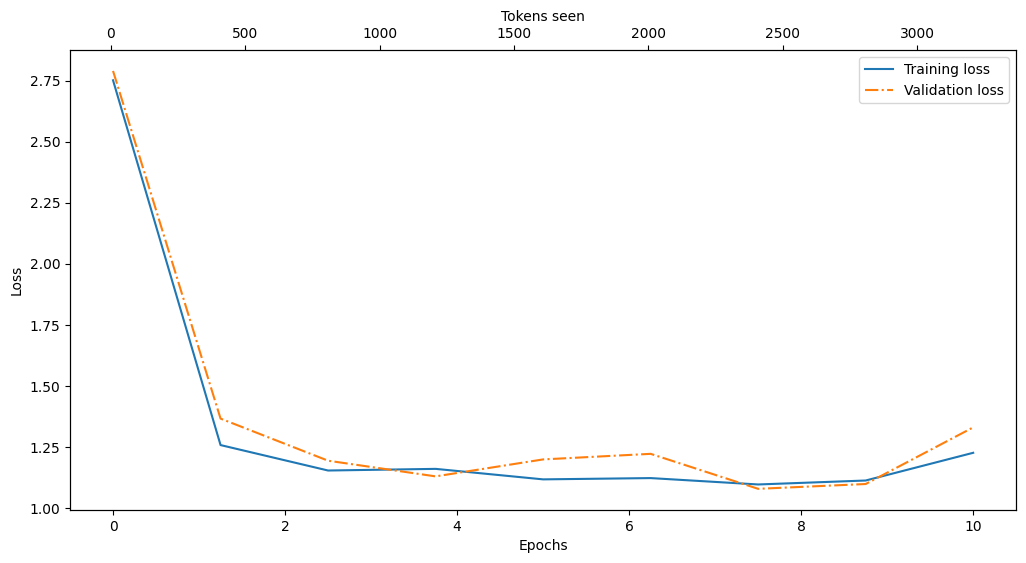

In [17]:
%matplotlib inline

def plot_losses(epochs_seen, tokens_seen, train_looses, validation_looses):
    plt.clf()
    fig, ax1 = plt.subplots()

    fig.set_figwidth(11)
    fig.set_figheight(6)
    fig.set_dpi(100)
    fig.tight_layout(pad=4)

    ax1.plot(epochs_seen, train_looses, label="Training loss")
    ax1.plot(epochs_seen, validation_losses, linestyle="-.", label="Validation loss")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax2 = ax1.twiny()
    ax2.plot(tokens_seen, train_losses, alpha=0)
    ax2.set_xlabel("Tokens seen")
    plt.show()

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, validation_losses)

### Plotting the Embedding Changes

In [18]:
trained_embeddings = model.token_embeddings.weight.clone().to("cpu")

In [19]:
def classify(word: str) -> int:
    if word in adjectives:
        return 0
    if word in nouns:
        return 1
    if word in verbs:
        return 2
    return 3

classes = {
    0: "Adjective",
    1: "Noun",
    2: "Verb",
    3: "Keyword",
}

classification = {token: classify(word) for token, word in tokenizer.int_to_str.items()}
classification

{0: 3,
 1: 3,
 2: 1,
 3: 0,
 4: 2,
 5: 2,
 6: 1,
 7: 1,
 8: 1,
 9: 0,
 10: 2,
 11: 0,
 12: 0,
 13: 2}

In [20]:
colors = {
    0: "tab:blue",
    1: "tab:green",
    2: "tab:red",
    3: "tab:purple",
}

<Figure size 640x480 with 0 Axes>

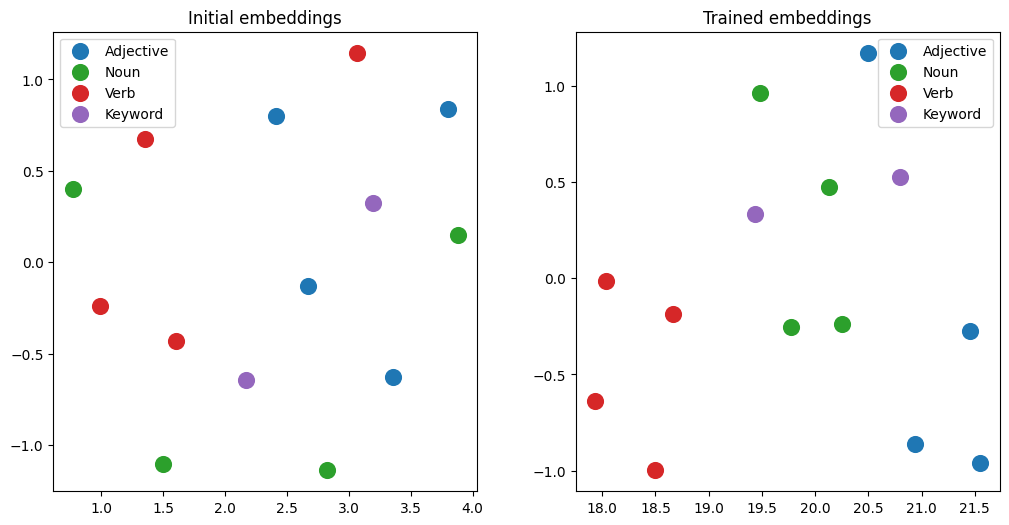

In [21]:
%matplotlib inline

def scat_umap_embeddings(ax: Axes, embeddings: torch.tensor, title: str):
    reducer = umap.UMAP(n_components = 2)
    reduced_embeddings = reducer.fit_transform(embeddings.tolist())
    groups = np.array(list(classification.values()))
    for group in np.unique(groups):
        selection = np.where(groups == group)
        ax.scatter(
            reduced_embeddings[selection][:, 0],
            reduced_embeddings[selection][:, 1],
            s = 128,
            c = colors[group],
            label = classes[group]
        )
    ax.legend()
    ax.set_title(title)

def plot_umap_embedding_changes():
    plt.clf()
    fig, (ax1, ax2) = plt.subplots(1, 2)
    
    fig.set_figwidth(11)
    fig.set_figheight(6)
    fig.set_dpi(100)
    fig.tight_layout(pad=4)
    
    scat_umap_embeddings(ax1, initial_embeddings, "Initial embeddings")
    scat_umap_embeddings(ax2, trained_embeddings, "Trained embeddings")
    
    plt.show()

plot_umap_embedding_changes()

In [22]:
def categorized_3d_scat(ax: Axes, values: torch.tensor, title: str):
    groups = np.array(list(classification.values()))
    for group in np.unique(groups):
        index = np.where(groups == group)
        ax.scatter(
            values[index][:, 0].detach().numpy(),
            values[index][:, 1].detach().numpy(),
            values[index][:, 2].detach().numpy(),
            s = 128,
            c = colors[group],
            label = classes[group]
        )
    ax.legend()
    ax.set_title(title)

def compare_3d_plots(
    initial_values: torch.tensor,
    final_values: torch.tensor,
    initial_title: str = "Initial",
    final_title: str = "Final"
):
    plt.clf()
    fig = plt.figure(1, 2)
    
    ax1 = fig.add_subplot(1, 2, 1, projection='3d')
    ax2 = fig.add_subplot(1, 2, 2, projection='3d')
    
    fig.set_figwidth(10)
    fig.set_figheight(6)
    fig.set_dpi(100)
    fig.tight_layout(pad=4)
    
    categorized_3d_scat(ax1, initial_values, initial_title)
    categorized_3d_scat(ax2, final_values, final_title)
    
    plt.show()

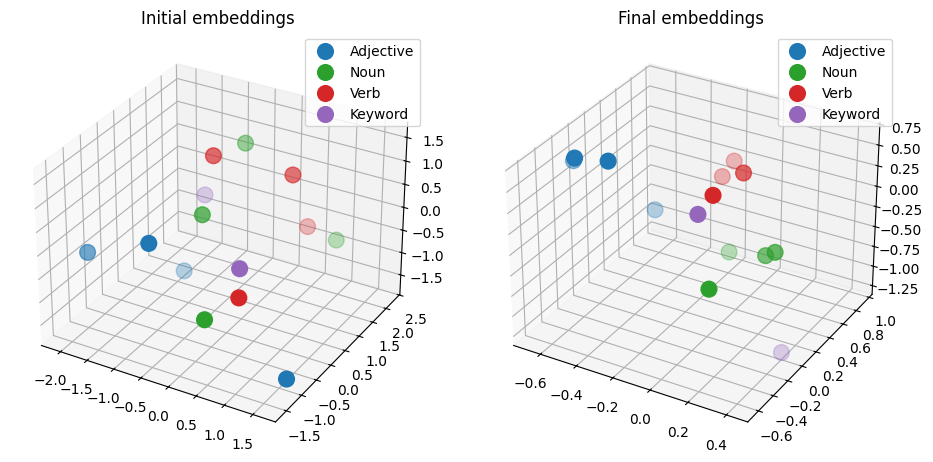

In [23]:
# Apparently only one chart can be rendered as an interactive widget at a time.
# Change this to %matplotlib widget to make this chart interactive.
# When you are done, set it back to %matplotlib inline.
%matplotlib inline

if config.embedding_dimension == 3:
    compare_3d_plots(initial_embeddings, trained_embeddings, "Initial embeddings", "Final embeddings")

### Plotting the Out-Head Changes

In [24]:
trained_out_head = model.out_head.weight.clone().to("cpu")

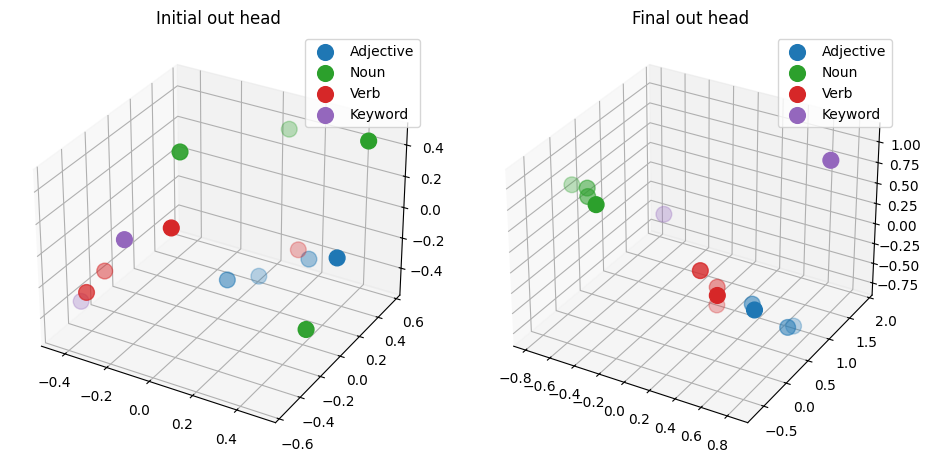

In [25]:
# Apparently only one chart can be rendered as an interactive widget at a time.
# Change this to %matplotlib widget to make this chart interactive.
# When you are done, set it back to %matplotlib inline.
%matplotlib inline

if config.embedding_dimension == 3:
    compare_3d_plots(initial_out_head, trained_out_head, "Initial out head", "Final out head")

## Debugging the Model

### Debugging the Inference

In [26]:
model.enable_debugging()

input_text = 'endless idea'
idx = tokenizer.text_to_tokens(input_text).to(trainer.device)
logits = model(idx)
next_idx = logits.argmax(dim = -1)
generated_text = tokenizer.tokens_to_text(next_idx)

model.disable_debugging()

In [27]:
def plot_bars(values: torch.tensor, labels: list, colors: list, title: str, suptitle: str):
    fig, ax = plt.subplots()

    fig.set_figwidth(10)
    fig.set_figheight(6)
    fig.set_dpi(100)
    fig.tight_layout(pad=4)

    ax.bar(labels, values.tolist(), color = colors)
    ax.set_title(title)
    fig.suptitle(suptitle)
    ax.set_xticklabels(labels, rotation=75)
    fig.show()

labels = tokenizer.int_to_str.values()
classification_colors = [colors[classification] for classification in classification.values()]

#### Plotting the Out Head

As we enabled `enable_debugging` before running the inference, we can now check the value of the `debug_bag`, where we'll found the output values of each layer.

In [28]:
out_head = model.debug_bag["out_head"].squeeze()

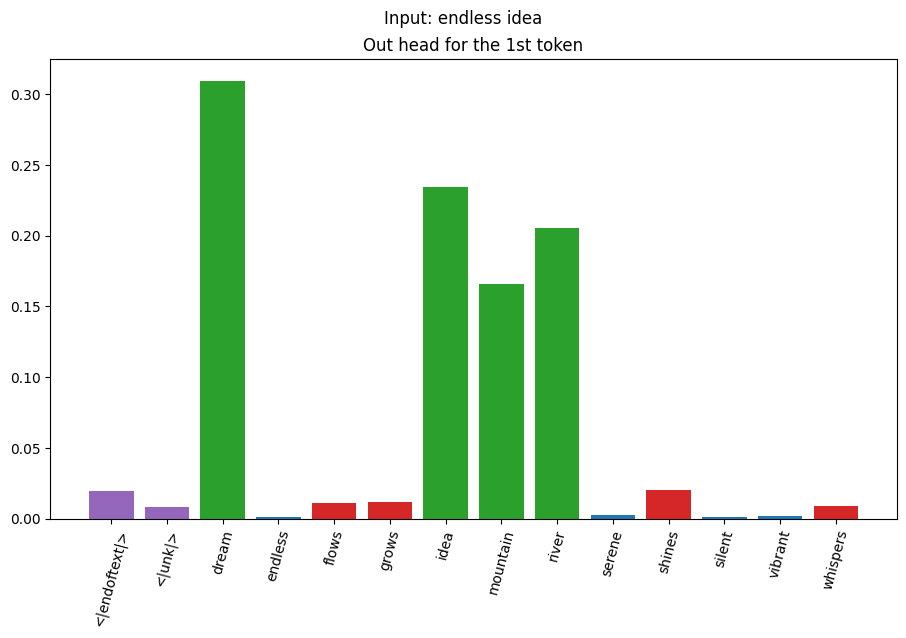

In [29]:
probs = out_head[0].softmax(dim = -1)
plot_bars(probs, labels, classification_colors, "Out head for the 1st token", "Input: " + input_text)

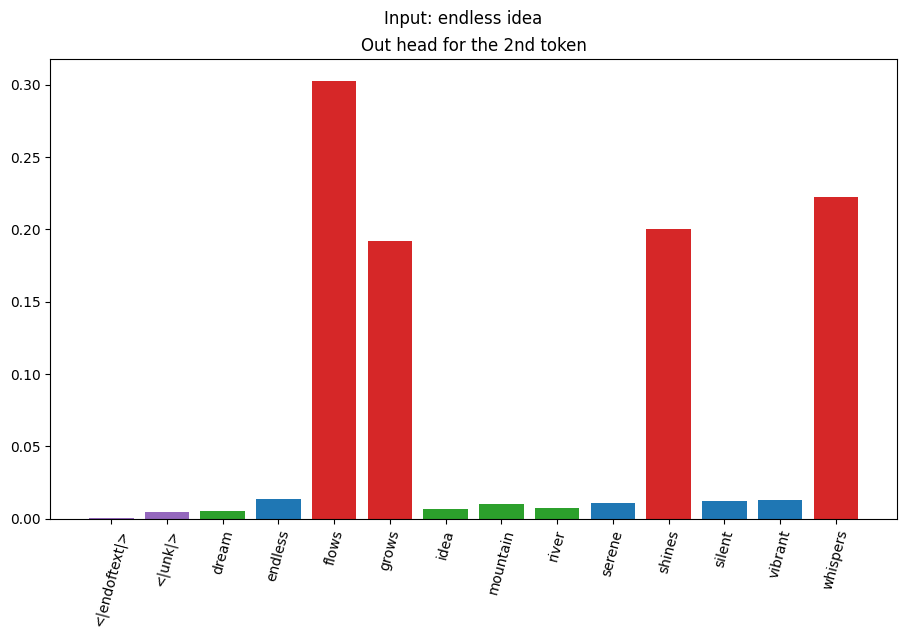

In [30]:
probs = out_head[1].softmax(dim = -1)
plot_bars(probs, labels, classification_colors, "Out head for the 2nd token", "Input: " + input_text)

#### Plotting the Latent Space Life Cycle

In [31]:
final_normalization = model.debug_bag["final_normalization"].squeeze().clone().to("cpu")
transformer_blocks = model.debug_bag["transformer_blocks"].squeeze().clone().to("cpu")
dropout_embeddings = model.debug_bag["dropout_embeddings"].squeeze().clone().to("cpu")
positional_embeddings = model.debug_bag["positional_embeddings"].squeeze().clone().to("cpu")
token_embeddings = model.debug_bag["token_embeddings"].squeeze().clone().to("cpu")

In [32]:
def scat_3d_embedding(ax: Axes, embedding: torch.tensor, color: str):
    ax.scatter(
        embedding[0].detach().numpy(),
        embedding[1].detach().numpy(),
        embedding[2].detach().numpy(),
        s = 128,
        color = color,
    )

In [33]:
def scat_token_cycle(ax: Axes, token_index: int, color: str):
    scat_3d_embedding(ax, token_embeddings[token_index], color)
    scat_3d_embedding(ax, positional_embeddings[token_index], color)
    scat_3d_embedding(ax, dropout_embeddings[token_index], color)
    scat_3d_embedding(ax, transformer_blocks[token_index], color)
    scat_3d_embedding(ax, final_normalization[token_index], color)

def plot_lines(ax: Axes, token_index: int, color: str):
    token_history = torch.stack([
        token_embeddings[token_index],
        positional_embeddings[token_index],
        dropout_embeddings[token_index],
        transformer_blocks[token_index],
        final_normalization[token_index],
    ])

    x = token_history[: ,0].detach().numpy(),
    y = token_history[: ,1].detach().numpy(),
    z = token_history[: ,2].detach().numpy(),

    ax.plot(x, y, z, color = color)

<Figure size 640x480 with 0 Axes>

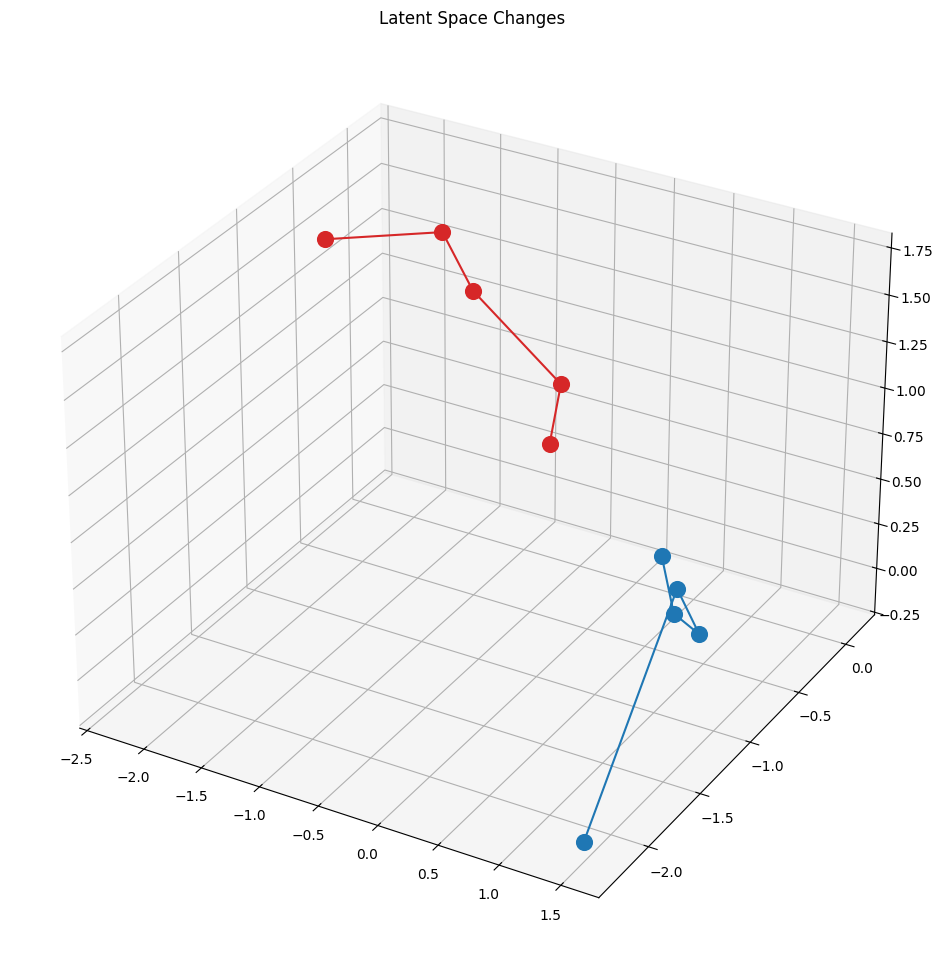

In [42]:
# Apparently only one chart can be rendered as an interactive widget at a time.
# Change this to %matplotlib widget to make this chart interactive.
# When you are done, set it back to %matplotlib inline.
%matplotlib inline

if config.embedding_dimension == 3:
    plt.clf()

    fig = plt.figure()
    fig.set_figwidth(24)
    fig.set_figheight(12)
    fig.set_dpi(100)
    fig.tight_layout(pad=4)
    
    ax = fig.add_subplot(projection='3d')
    
    scat_token_cycle(ax, 0, "tab:red")
    plot_lines(ax, 0, "tab:red")

    scat_token_cycle(ax, 1, "tab:blue")
    plot_lines(ax, 1, "tab:blue")

    plt.title("Latent Space Changes")

    plt.show()